In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import *

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import dal
warnings.filterwarnings("ignore")

snow_runner = dal.SnowflakeRunner()

In [3]:
conversations_public = snow_runner.get_data_raw('queries/conversations_public.sql')
df = pd.DataFrame(conversations_public)

In [4]:
project_users = snow_runner.get_data_raw('queries/project_to_staff.sql')
df_project_users = pd.DataFrame(project_users)

In [5]:
dict_cursor_roles = snow_runner.get_data_raw('queries/user_roles.sql')

In [6]:
projects = list(set(df.PROJECT_ID))
list_net = []
for project in  projects:
    user_list = list(set(df[df.PROJECT_ID == project].USER_ID))
    data = list(filter(lambda x: x['PROJECT_ID'] == project, conversations_public))
    roles = list(filter(lambda x: x['USER_ID'] in user_list, dict_cursor_roles))
    list_net.append({'project_id':project, 'network': build_network(data, roles)})

In [8]:
project_density = []
for project in projects:
    G = [i for i in filter(lambda x: x['project_id'] == project, list_net)][0]['network']
    density = nx.density(G)
    project_density.append({'project_id': project, 'density': density})

In [9]:
## Investigate hown the metrics are defined in networkX for weighted graphs and send email to Albert

In [10]:
df_density = pd.DataFrame(project_density).set_index('project_id')

In [11]:
project_clustering = []
for project in projects:
    G = [i for i in filter(lambda x: x['project_id'] == project, list_net)][0]['network']
    clustering = nx.density(G)
    project_clustering.append({'project_id': project, 'clustering': clustering})

In [12]:
df_clustering = pd.DataFrame(project_clustering).set_index('project_id')

In [13]:
df_metrics = df_density.join(df_clustering, how = 'left')

In [14]:
project_on_time = snow_runner.get_data_raw('queries/project_on_time.sql')
df_project_on_time = pd.DataFrame(project_on_time)

In [15]:
df_project_on_time.set_index('PROJECT_ID', inplace = True)

In [16]:
df_full = df_project_on_time.join(df_metrics, how = 'inner')
df_full_filtered = df_full[pd.notnull(df_full.IS_ONTIME)]

In [17]:
df_nusers = pd.DataFrame(df_project_users.groupby('PROJECT_ID').USER_ID.nunique())
df_nusers.columns = ['n_users']

In [18]:
df_final= df_full_filtered.join(df_nusers, how = 'inner')

In [19]:
df_final.reset_index().groupby('n_users').index.nunique()

n_users
1        4
2       81
3      202
4      601
5     1117
6      768
7      329
8      152
9       68
10      51
11      32
12       5
13       3
15       1
Name: index, dtype: int64

In [20]:
df_final = df_final[(df_final.n_users > 3) & (df_final.n_users < 8)  & (df_final.density < 3)]

In [21]:
not_on_time = df_final[df_final.IS_ONTIME == False].density
on_time = df_final[df_final.IS_ONTIME == True].density

{'whiskers': [<matplotlib.lines.Line2D at 0x174ef18b0>,
 'caps': [<matplotlib.lines.Line2D at 0x174d4f0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x174ef1280>],
 'medians': [<matplotlib.lines.Line2D at 0x174d4f520>],
 'fliers': [<matplotlib.lines.Line2D at 0x174d4f910>],
 'means': []}

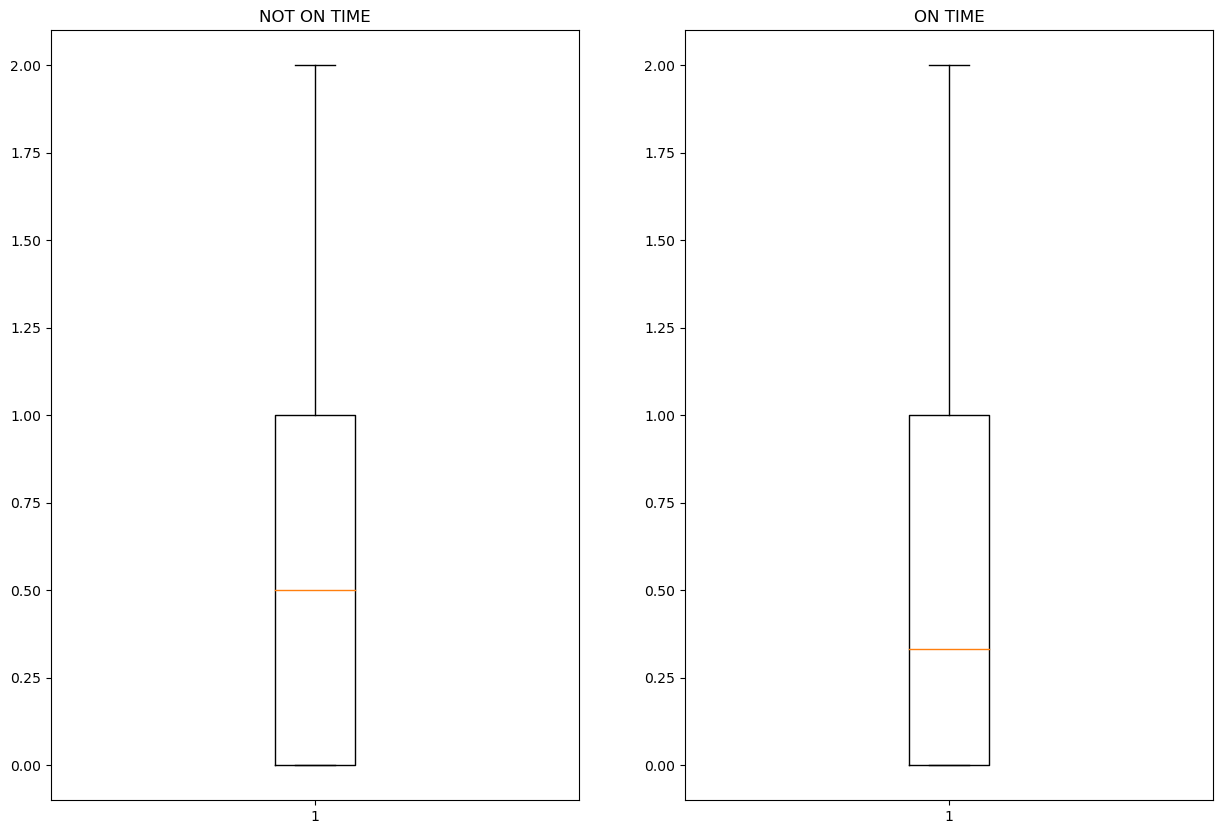

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].set_title('NOT ON TIME')
axes[0].boxplot(not_on_time)
axes[1].set_title('ON TIME')
axes[1].boxplot(on_time)

In [23]:
n1 = len(df_final[df_final.IS_ONTIME == True])
n2 = len(df_final[(df_final.IS_ONTIME == False) ])
s1 = np.var(df_final[df_final.IS_ONTIME == True].density)
s2 = np.var(df_final[(df_final.IS_ONTIME == False) ].density)
m1 = df_final[df_final.IS_ONTIME == True].density.mean()
m2 = df_final[(df_final.IS_ONTIME == False) ].density.mean()

In [24]:
significance(n1, n2, s1, s2, m1, m2)

The difference is significant


-1.7513258308463622

In [25]:
s1 = np.var(df_final[df_final.IS_ONTIME == True].n_users)
s2 = np.var(df_final[(df_final.IS_ONTIME == False) ].n_users)
m1 = df_final[df_final.IS_ONTIME == True].n_users.mean()
m2 = df_final[(df_final.IS_ONTIME == False) ].n_users.mean()

In [26]:
significance(n1, n2, s1, s2, m1, m2)

The difference is NOT significant


-0.6350895713499181

In [27]:
df_final.reset_index(inplace=True)

In [28]:
df_final.columns = ['PROJECT_ID','EDED_TO_DEADLINE', 'IS_ONTIME', 'density', 'clustering', 'n_users']

In [29]:
csvs = os.path.abspath(os.path.join('..', 'csvs'))
df_final[['PROJECT_ID','IS_ONTIME', 'density', 'clustering']].to_csv(os.path.join('project.csv'), index=False)

In [33]:
ks_sample_test(df_final[df_final.IS_ONTIME == True].density, df_final[df_final.IS_ONTIME == False].density)

0.08568042740103862

In [34]:
ks_sample_test(df_final[df_final.IS_ONTIME == True].clustering, df_final[df_final.IS_ONTIME == False].clustering)

0.08568042740103862